In [19]:
import os
import torch
import librosa
import torchaudio
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchaudio.transforms as T
from sklearn.model_selection import train_test_split

In [24]:
Dataset_x=torch.tensor([])
Dataset_y=torch.tensor([])

mel_spec_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=44100,
    n_mels=30,
    n_fft=512,
    hop_length=256,
    f_min=0,
)

major_path="./Audio_Files/Major/"
for filename in os.listdir(major_path):
    f = os.path.join(major_path, filename)
    waveform,sr=torchaudio.load(f)
    waveform=mel_spec_transform(waveform)
    waveform=torch.nn.functional.pad(waveform, (0, 400-waveform.shape[2]), mode='constant', value=0)
    Dataset_x=torch.cat((Dataset_x,waveform))
    Dataset_y=torch.cat((Dataset_y,torch.tensor([[1,0]])))

minor_path="./Audio_Files/Minor/"
for filename in os.listdir(minor_path):
    f = os.path.join(minor_path, filename)
    waveform,sr=torchaudio.load(f)
    waveform=mel_spec_transform(waveform)
    waveform=torch.nn.functional.pad(waveform, (0, 400-waveform.shape[2]), mode='constant', value=0)
    Dataset_x=torch.cat((Dataset_x,waveform))
    Dataset_y=torch.cat((Dataset_y,torch.tensor([[0,1]])))

mean = Dataset_x.mean()
std = Dataset_x.std()
Dataset_x = (Dataset_x - mean) / std

train_x, rem_x, train_y,rem_y = train_test_split(Dataset_x,Dataset_y, train_size=0.7,shuffle=True)
val_x,test_x,val_y,test_y=train_test_split(rem_x,rem_y, train_size=0.5,shuffle=True)
train_x = train_x.unsqueeze(1)
val_x = val_x.unsqueeze(1)

In [27]:
class CNN(nn.Module):
    def __init__(self,shape):
        super(CNN,self).__init__()
        self.conv1=nn.Sequential(
            nn.Conv2d(
            in_channels=1,
            out_channels=64,
            kernel_size=3,
            padding=2
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.3)
        )
        self.conv2=nn.Sequential(
            nn.Conv2d(
            in_channels=64,
            out_channels=128,
            kernel_size=3,
            padding=2
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.3)
        )
        """self.conv3=nn.Sequential(
            nn.Conv2d(
            in_channels=128,
            out_channels=128,
            kernel_size=3,
            padding=2
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.3)
        )"""
        conv_size=self._get_conv_out(shape)
        self.linear1=nn.Linear(conv_size,128)
        self.linear2=nn.Linear(128,2)

    def _get_conv_out(self,shape):
        out = self.conv1(torch.zeros(1,*shape))
        out=self.conv2(out)
        #out=self.conv3(out)
        result = int(np.prod(out.size()))
        return result
    
    def forward(self,x):
        x=self.conv1(x)
        x=self.conv2(x)
        #x=self.conv3(x)
        x=x.view(x.size(0),-1)
        x=self.linear1(x)
        x=self.linear2(x)
        return x


4.035729025842346 0.5291181364392679 20.359138 0.5658914728682171
0.4208493859517991 0.47088186356073214 6.5944953 0.5658914728682171
0.1264142815562929 0.45923460898502494 1.6710246 0.5658914728682171
0.04155344971007793 0.4891846921797005 0.9578785 0.5348837209302325
0.03313360357046524 0.4891846921797005 0.8439176 0.5116279069767442
0.027005847797615952 0.5124792013311148 0.9516285 0.4806201550387597
0.026060220207430162 0.5590682196339434 0.9316556 0.4418604651162791
0.026231299224193403 0.5374376039933444 0.9537677 0.4883720930232558
0.026598179796571145 0.5374376039933444 0.72543746 0.5348837209302325
0.025338853655162946 0.5324459234608985 0.7118047 0.5813953488372093
0.026292604138569507 0.5690515806988353 0.8382398 0.5426356589147286
0.02571236393019284 0.5357737104825291 0.7766858 0.5503875968992248
0.025209933073072385 0.5490848585690515 0.81565076 0.5426356589147286
0.026744325228419755 0.5307820299500832 0.7051487 0.5736434108527132
0.025995175175976236 0.5008319467554077 

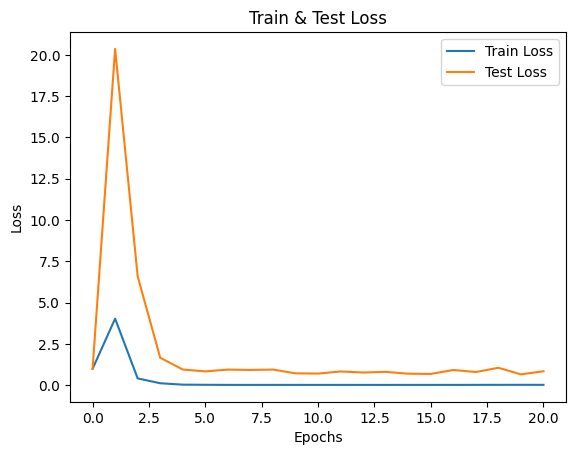

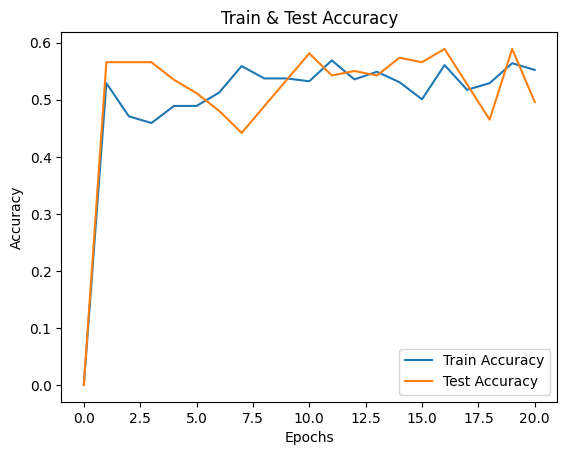

In [28]:
epochs=20
batch=29
model=CNN(train_x[0].shape)
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.01,weight_decay=0.0001)

train_loss=[1]
train_accu=[0]
val_loss=[1]
val_accu=[0]
for epoch in range(epochs):
    model.train()
    l=0
    a=0
    batch_num=0
    for i in range(0,len(train_x),batch): 
        batch_num+=1
        x_batch = train_x[i:i+batch] 
        y_batch = train_y[i:i+batch]
        out=model(x_batch)

        loss=criterion(out,y_batch)
        l+=loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        a+=np.sum(np.argmax(out.detach().numpy(),axis=1)==np.argmax(y_batch.detach().numpy(),axis=1))
    train_loss.append(l.detach().numpy()/len(train_x))
    train_accu.append(a/len(train_x))
    
    with torch.no_grad():
        out=model(val_x)
        loss=criterion(out,val_y)
        val_accu.append(np.sum(np.argmax(out.detach().numpy(),axis=1)==np.argmax(val_y.detach().numpy(),axis=1))/len(val_x))
        val_loss.append(loss.detach().numpy())
    print(train_loss[-1],train_accu[-1],val_loss[-1],val_accu[-1])
plt.plot(range(epochs+1),train_loss)
plt.plot(range(epochs+1),val_loss)
plt.legend(['Train Loss','Test Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train & Test Loss')
plt.show()

plt.plot(range(epochs+1),train_accu)
plt.plot(range(epochs+1),val_accu)
plt.legend(['Train Accuracy','Test Accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train & Test Accuracy')
plt.show()



In [ ]:

waveform,sr=torchaudio.load('/Users/lijingyang/Desktop/EE541_Project/Audio_Files/Major/Major_3.wav')
mel_spec_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=sr,
    n_mels=30,      # decrease the value of n_mels
    n_fft=512,
    hop_length=256,
    f_min=0,
    f_max=5000
)
waveform=mel_spec_transform(waveform)


In [102]:
waveform.shape

torch.Size([1, 30, 388])

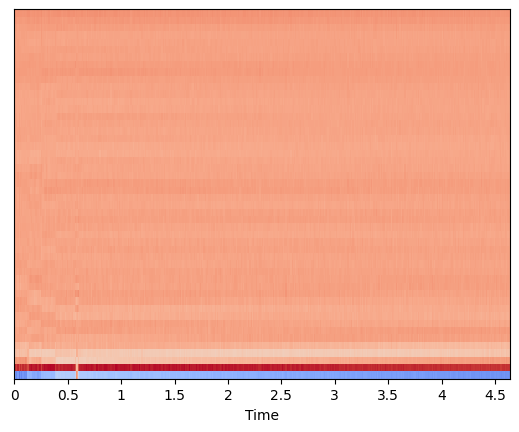

In [130]:
librosa.display.specshow(Dataset_x[0].numpy(), sr=sr, x_axis='time')

In [49]:


def get_mfcc(file_path,sr=44100,fmax=5000):
    wav_data , sr = librosa.load(path=file_path,sr=sr,duration=4)
    wav_data=normalize(wav_data)
    mfcc=librosa.feature.mfcc(y=wav_data, sr=sr,fmax=fmax)
    return mfcc[0:20,0:190],sr
    

def loadedata(data_path):
    major_path=data_path+'Major/'
    minor_path=data_path+'Minor/'
    x_data=[]
    y_data=[]
    for filename in os.listdir(minor_path):
        f = os.path.join(minor_path, filename)
        if os.path.isfile(f):
            mfcc,sr=get_mfcc(f)
            print(mfcc.shape)
            #librosa.display.specshow(mfcc, sr=sr, x_axis='time')
            #plt.show()

class WAVDataset(Dataset):
    def __init__(self):
        self.data_path='./Audio_Files/'
        file_list=glob.glob(self.data_path+"*")
        print(file_list)

In [50]:
data_path='./Audio_Files/'
loadedata(data_path)

(20, 194)
(20, 190)
(20, 194)
(20, 190)
(20, 190)
(20, 190)
(20, 194)
(20, 190)
(20, 194)
(20, 190)
(20, 194)
(20, 190)
(20, 194)
(20, 190)
(20, 199)
(20, 190)
(20, 194)
(20, 190)
(20, 194)
(20, 190)
(20, 194)
(20, 190)
(20, 194)
(20, 190)
(20, 199)
(20, 190)
(20, 194)
(20, 190)
(20, 194)
(20, 190)
(20, 194)
(20, 190)
(20, 194)
(20, 190)
(20, 190)
(20, 190)
(20, 194)
(20, 190)
(20, 194)
(20, 190)
(20, 194)
(20, 190)
(20, 199)
(20, 190)
(20, 194)
(20, 190)
(20, 199)
(20, 190)
(20, 194)
(20, 190)
(20, 190)
(20, 190)
(20, 190)
(20, 190)
(20, 190)
(20, 190)
(20, 194)
(20, 190)
(20, 194)
(20, 190)
(20, 199)
(20, 190)
(20, 199)
(20, 190)
(20, 194)
(20, 190)
(20, 194)
(20, 190)
(20, 190)
(20, 190)
(20, 190)
(20, 190)
(20, 190)
(20, 190)
(20, 194)
(20, 190)
(20, 199)
(20, 190)
(20, 194)
(20, 190)
(20, 199)
(20, 190)
(20, 194)
(20, 190)
(20, 190)
(20, 190)
(20, 190)
(20, 190)
(20, 199)
(20, 190)
(20, 199)
(20, 190)
(20, 190)
(20, 190)
(20, 194)
(20, 190)
(20, 190)
(20, 190)
(20, 199)
(20, 190)


In [2]:
audio_path = './Audio_Files/Major/Major_0.wav'
x , sr = librosa.load(audio_path,sr=44100)
print(type(x), type(sr))

<class 'numpy.ndarray'> <class 'int'>


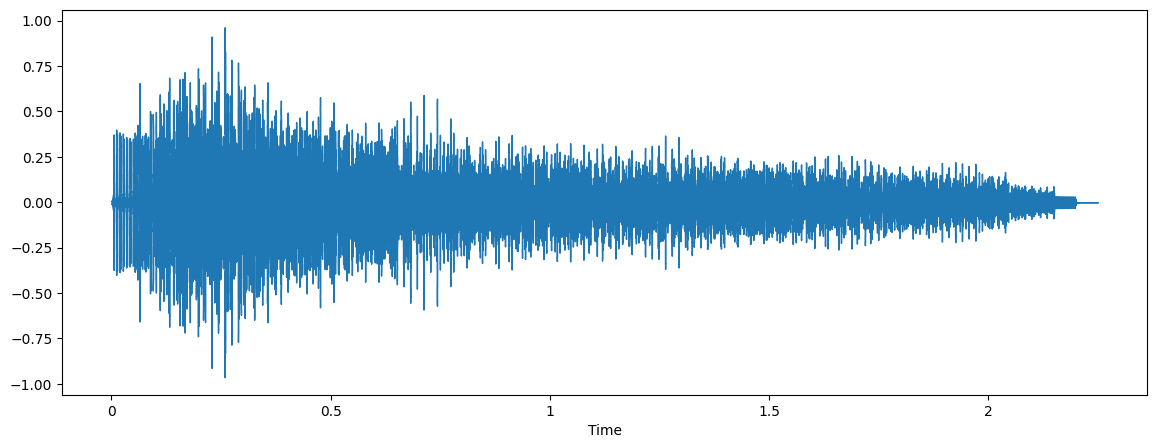

In [3]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=sr)
plt.show()

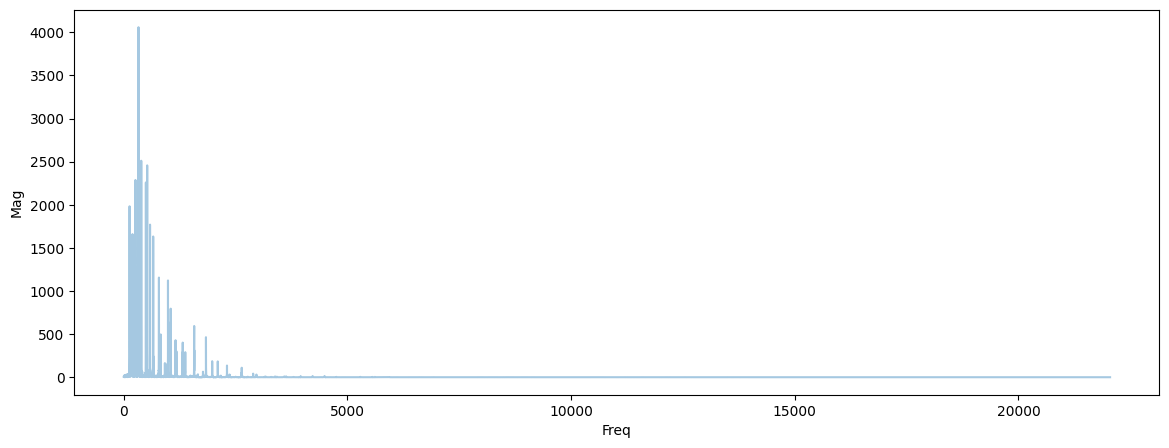

In [4]:
fft = np.fft.fft(x)
spectrum = np.abs(fft)
left_spectrum = spectrum[:int(len(spectrum)/2)]
f = np.linspace(0, sr, len(spectrum))
left_f = f[:int(len(spectrum)/2)]
# plot spectrum
plt.figure(figsize=(14, 5))
plt.plot(left_f, left_spectrum, alpha=0.4)
plt.xlabel("Freq")
plt.ylabel("Mag")
plt.show()

[[ 14.152242    11.52232      8.782944   ... -34.04889    -40.02326
  -40.02326   ]
 [ 15.0149975   14.844956     9.042734   ... -34.014545   -40.02326
  -40.02326   ]
 [ 16.583363    14.700385     0.28246328 ... -33.866047   -40.02326
  -40.02326   ]
 ...
 [-40.02326    -40.02326    -40.02326    ... -40.02326    -40.02326
  -40.02326   ]
 [-40.02326    -40.02326    -40.02326    ... -40.02326    -40.02326
  -40.02326   ]
 [-40.02326    -40.02326    -40.02326    ... -40.02326    -40.02326
  -40.02326   ]]


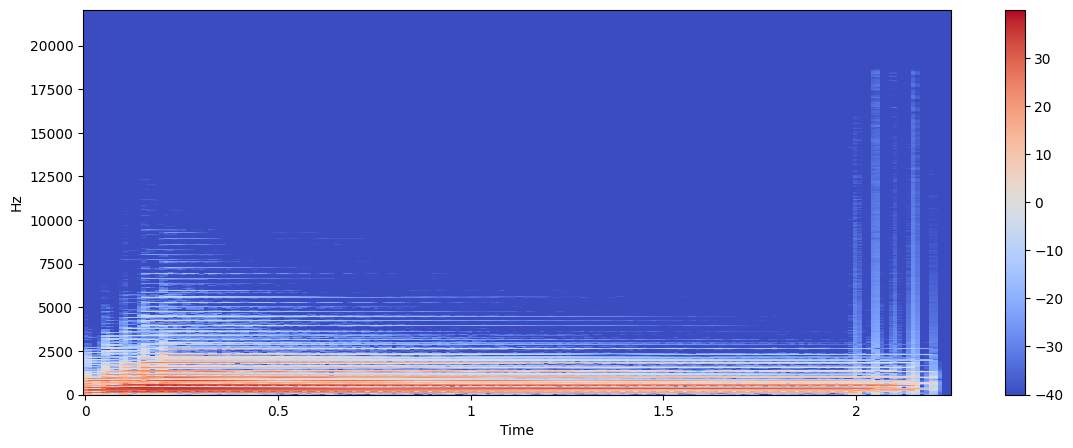

In [10]:
#display Spectrogram
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
print(Xdb)
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz') 
#If to pring log of frequencies  
#librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

(20, 194)


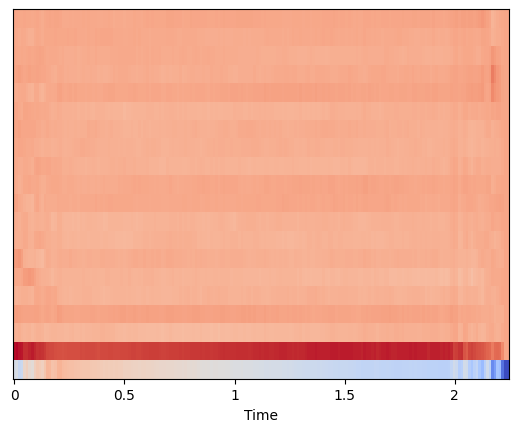

In [17]:
mfccs = librosa.feature.mfcc(y=x, sr=sr,fmax=5000)
print(mfccs.shape)
#Displaying  the MFCCs:
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

In [ ]:
from troch